In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, PrecisionRecallDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFE,RFECV
from sklearn.pipeline import Pipeline
import os
import other_ml_models
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model
from feature_engineering import FeatureEngineering
from catboost import CatBoostClassifier, Pool, metrics, cv
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 500)

In [44]:
df_train, df_test = FeatureEngineering("data/all_game_data_milesstone_2.csv").train_test_split()

In [4]:
df_train

,event_type,gameID,gameType,home,away,season,eventID,gameID_eventID,game_time,game_period,team,x_coordinate,y_coordinate,shot_type,is_goal,shooter,goalie,game_seconds,time_from_last_event,last_x_coordinate,last_y_coordinate,last_event,distance_from_last_event,rebound,speed,power_play_time,time_since_powerplay_started,num_friendly_non_goalie_skaters,num_opposing_non_goalie_skaters,is_emptyNet,strength,distance_to_positive_goal,distance_to_negative_goal,goal_coordinate,shot_distance_to_goal,shot_angle,change_in_shot_angle,goal_rate_dist,goal_rate_angle
134354,Shot,2018020811,R,Florida Panthers,St. Louis Blues,20182019,53,2018020811_53,2019-02-06T00:10:51Z,1,Florida Panthers,-39.0,-33.0,Snap Shot,0,Riley Sheahan,Jordan Binnington,98,48,44.0,25.0,Giveaway,101.257099,False,2.109523,0,0,5,5,0,NaN,127.349912,55.803226,-84,55.803226,36.253838,0.0,0.001701,0.002618
134355,Shot,2018020811,R,Florida Panthers,St. Louis Blues,20182019,56,2018020811_56,2019-02-06T00:12:23Z,1,Florida Panthers,-47.0,23.0,Snap Shot,0,Colton Sceviour,Jordan Binnington,165,7,34.0,-31.0,Missed Shot,97.349884,False,13.907126,0,0,5,5,0,NaN,133.003759,43.566042,-84,43.566042,-31.865978,0.0,0.002179,-0.002979
134356,Shot,2018020811,R,Florida Panthers,St. Louis Blues,20182019,57,2018020811_57,2019-02-06T00:13:03Z,1,Florida Panthers,-78.0,5.0,Snap Shot,0,Aleksander Barkov,Jordan Binnington,205,5,80.0,24.0,Giveaway,159.138305,False,31.827661,0,0,5,5,0,NaN,162.077142,7.810250,-84,7.810250,-39.805571,0.0,0.012153,-0.002384
134357,Shot,2018020811,R,Florida Panthers,St. Louis Blues,20182019,60,2018020811_60,2019-02-06T00:14:04Z,1,Florida Panthers,-39.0,-13.0,Snap Shot,0,Jonathan Huberdeau,Jordan Binnington,212,0,NaN,NaN,Stoppage,NaN,False,NaN,0,0,5,5,0,NaN,123.685084,46.840154,-84,46.840154,16.113418,0.0,0.002026,0.005890
134358,Shot,2018020811,R,Florida Panthers,St. Louis Blues,20182019,66,2018020811_66,2019-02-06T00:15:59Z,1,Florida Panthers,-76.0,-32.0,Backhand,0,MacKenzie Weegar,Jordan Binnington,313,18,-37.0,-23.0,Missed Shot,40.024992,False,2.223611,0,0,5,5,0,NaN,163.168624,32.984845,-84,32.984845,75.963757,0.0,0.002878,0.001249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382388,Goal,2016020295,R,Nashville Predators,Dallas Stars,20162017,602,2016020295_602,2016-11-24T03:22:15Z,3,Nashville Predators,81.0,5.0,Wrist Shot,1,Craig Smith,Kari Lehtonen,709,2,50.0,12.0,Takeaway,31.780497,False,15.890249,0,0,5,5,0,Even,5.830952,165.075740,84,5.830952,59.036243,0.0,0.016278,0.001608
382389,Shot,2016020295,R,Nashville Predators,Dallas Stars,20162017,604,2016020295_604,2016-11-24T03:23:21Z,3,Dallas Stars,-84.0,33.0,Wrist Shot,0,Jason Spezza,Pekka Rinne,727,18,0.0,0.0,Faceoff,90.249654,False,5.013870,0,0,5,5,0,NaN,171.210397,33.000000,-84,33.000000,-90.000000,0.0,0.002876,-0.001055
382390,Shot,2016020295,R,Nashville Predators,Dallas Stars,20162017,617,2016020295_617,2016-11-24T03:30:46Z,3,Dallas Stars,-30.0,-1.0,Snap Shot,0,Julius Honka,Pekka Rinne,1008,6,84.0,1.0,Missed Shot,114.017543,False,19.002924,0,0,5,5,0,NaN,114.004386,54.009258,-84,54.009258,1.060912,0.0,0.001757,0.089466
382391,Goal,2016020295,R,Nashville Predators,Dallas Stars,20162017,624,2016020295_624,2016-11-24T03:36:11Z,3,Dallas Stars,-77.0,-5.0,Backhand,1,Brett Ritchie,Pekka Rinne,1164,4,-81.0,3.0,Missed Shot,8.944272,False,2.236068,0,0,5,5,0,Even,161.077621,8.602325,-84,8.602325,35.537678,0.0,0.011034,0.002671


In [5]:
df_train.columns

Index(['event_type', 'gameID', 'gameType', 'home', 'away', 'season', 'eventID',
       'gameID_eventID', 'game_time', 'game_period', 'team', 'x_coordinate',
       'y_coordinate', 'shot_type', 'is_goal', 'shooter', 'goalie',
       'game_seconds', 'time_from_last_event', 'last_x_coordinate',
       'last_y_coordinate', 'last_event', 'distance_from_last_event',
       'rebound', 'speed', 'power_play_time', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'is_emptyNet', 'strength', 'distance_to_positive_goal',
       'distance_to_negative_goal', 'goal_coordinate', 'shot_distance_to_goal',
       'shot_angle', 'change_in_shot_angle', 'goal_rate_dist',
       'goal_rate_angle'],
      dtype='object')

Split into Train and Validation sets

In [15]:
train_cols = ['x_coordinate', 'y_coordinate', 'last_x_coordinate',
       'last_y_coordinate', 'distance_from_last_event', 'last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'is_emptyNet', 'shot_type', 'shot_distance_to_goal',
       'shot_angle', 'change_in_shot_angle']

X = df_train[train_cols]
X.rebound = X.rebound.astype(int)
df_test.rebound = df_test.rebound.astype(int)
y = df_train["is_goal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

/var/folders/47/th8gfrqd2k977395fgq4b6vh0000gn/T/ipykernel_84821/2070492032.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rebound = X.rebound.astype(int)


# CatBosst

## Create Pipeline

In [9]:
os.environ["COMET_API_KEY"] = "h85xbEnyF7lyFkSRYhBshWV8E"

In [10]:
experiment = Experiment(
  api_key=os.environ.get("COMET_API_KEY"),
  project_name="nhl-data-science",
  workspace="mahmoodhegazy"
)

[experiment.log_dataset_hash(data_set) for data_set in [X_train, X_test, y_train, y_test]]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/5099680072f7468a9e7d2cec05526378



[None, None, None, None]

In [9]:
params = {
    'n_estimators': 'n_estimators',
    'learning_rate': 'learning_rate',
    'max_depth': 'max_depth',
    'min_data_in_leaf': 'min_data_in_leaf',
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
clf_cat = CatBoostClassifier()
recursive_cv_feature_selection = RFECV( min_features_to_select=1,estimator=LinearRegression())
cat_pipe = other_ml_models.create_pipeline(classifier=clf_cat,feature_selection=recursive_cv_feature_selection)

In [24]:
cat_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2d9ea7d50>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2d9ea4490>)])),
                ('feature_select', RFECV(estimator=LinearRegression())),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x2d9ea5e10>)])

## Grid Search Hyperparamtuning

In [30]:
param_grid = {'classifier__n_estimators': [100, 300, 500],
                'classifier__learning_rate': [0.1, 0.01],
                'classifier__max_depth': [6, 12, 18],
                'classifier__min_data_in_leaf': [1, 2],
}

# Fit a 3-fold GridSearchCV
cat_gs = GridSearchCV(cat_pipe, param_grid, cv=2, verbose=1, n_jobs=-1)
cat_gs.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:")
print(cat_gs.best_params_)
print("Grid scores:")
means = cat_gs.cv_results_['mean_test_score']
stds = cat_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cat_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Fitting 2 folds for each of 36 candidates, totalling 72 fits


/Users/mahmoodhegazy/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/mahmoodhegazy/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
24 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mahmoodhegazy/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "

Best parameters:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_data_in_leaf': 1, 'classifier__n_estimators': 300}
Grid scores:
0.927 (+/-0.001) for {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_data_in_leaf': 1, 'classifier__n_estimators': 100}
0.928 (+/-0.000) for {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_data_in_leaf': 1, 'classifier__n_estimators': 300}
0.928 (+/-0.000) for {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_data_in_leaf': 1, 'classifier__n_estimators': 500}
0.927 (+/-0.001) for {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_data_in_leaf': 2, 'classifier__n_estimators': 100}
0.928 (+/-0.000) for {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_data_in_leaf': 2, 'classifier__n_estimators': 300}
0.928 (+/-0.000) for {'classifier__learning_rate': 0.1, 'classifier__max_depth'

Train on best Hyperparams

In [10]:
clf_cat = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)

In [11]:
clf_cat.fit(X_train,y_train, cat_features=[4,12], eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
## Best Catboost
best_cat_params = {
    'n_estimators': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
cat_clf= CatBoostClassifier(**best_cat_params)
recursive_cv_feature_selection = RFECV( min_features_to_select=1,estimator=LinearRegression())
cat_best_pipe = other_ml_models.create_pipeline(classifier=cat_clf,feature_selection=recursive_cv_feature_selection)

In [26]:
cat_best_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x318da4990>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x318da4e50>)])),
                ('feature_select', RFECV(estimator=LinearRegression())),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x177184950>)])

## Logging Validation Scores

In [27]:
preds = cat_best_pipe.predict(X_test)
preds_train = cat_best_pipe.predict(X_train)

print("Accuracy (train): ", accuracy_score(y_train,preds_train))
print("Accuracy (test): ", accuracy_score(y_test,preds))
print("Classification report:\n", classification_report(y_test,preds))

Accuracy (train):  0.9465580902918604
Accuracy (test):  0.9478330489012494
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     43126
           1       0.99      0.43      0.60      4337

    accuracy                           0.95     47463
   macro avg       0.97      0.72      0.79     47463
weighted avg       0.95      0.95      0.94     47463



In [29]:
preds_prob = cat_best_pipe.predict_proba(X_test)

{'web': 'https://www.comet.com/api/image/download?imageId=553c3e32728b4a6185dad0d083003f74&experimentKey=5099680072f7468a9e7d2cec05526378',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=553c3e32728b4a6185dad0d083003f74&experimentKey=5099680072f7468a9e7d2cec05526378',
 'imageId': '553c3e32728b4a6185dad0d083003f74'}

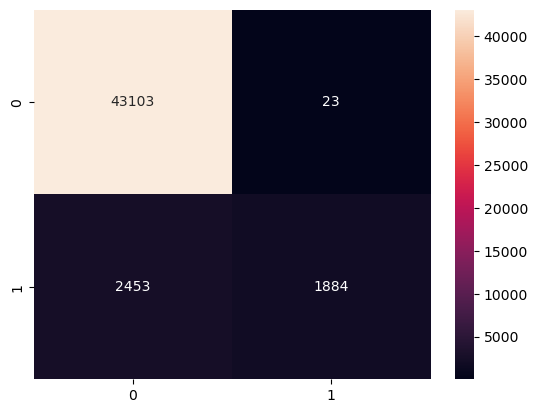

In [30]:
cm=confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True,fmt="d")
experiment.log_figure(figure_name='Confusion Matrix', step=None)

In [32]:
metrics = {"accuracy": accuracy_score(y_test, preds), "f1": f1_score(y_test, preds), "recall": recall_score(y_test, preds), "precision": precision_score(y_test, preds)}
parameter = {
    "model_type": 'Catboost',
    "param_grid": str(cat_best_pipe.get_params()),
}
experiment.log_parameters(parameter)
experiment.log_metrics(metrics)

COMET WARNING: truncated string; too long: '{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x318da4990>),
                                ('Categorical_transform',
                                 Pipeline(steps=[('Impt',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x318da4e50>)])), ('featu

### Prec-Recall Curve

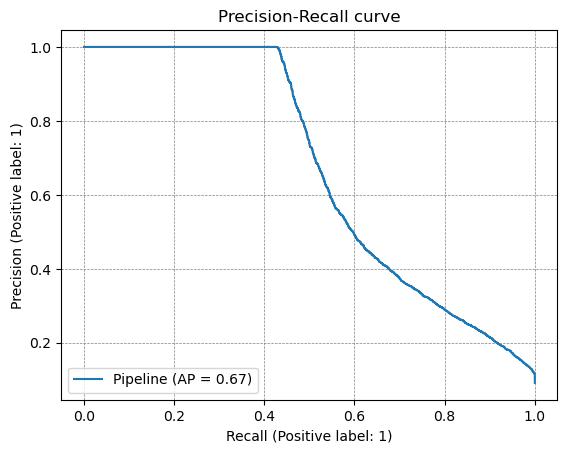

In [33]:
other_ml_models.plot_precision_recall(model=cat_best_pipe, X_test=X_test, y_test=y_test, experiment=experiment)

### ROC Curve

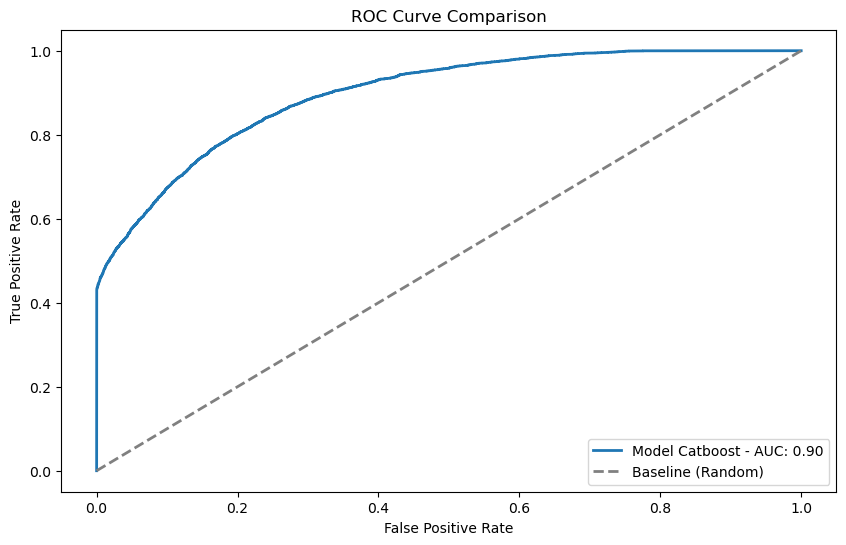

In [34]:
plt.figure(figsize=(10, 6))
line_width = 2

false_positive_rate, true_positive_rate, _ = roc_curve(y_test.ravel(),preds_prob[:,1].ravel())
area_under_curve = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, lw=line_width, label=f"Model Catboost - AUC: {area_under_curve:.2f}")

plt.plot([0, 1], [0, 1], color="grey", lw=line_width, linestyle='--', label="Baseline (Random)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
experiment.log_figure(figure_name='ROC-AUC', step=None)
plt.show()

### Goal Rate Plot

In [35]:
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))
df_prob = pd.DataFrame(list(zip(preds ,y_test ,preds_prob[:,1]*100)), columns = ['goal_pred', 'goal','goal_probability'])
df_prob['shot'] = 1
sum_goal = df_prob['goal'].sum()
df_prob['percentile'] = df_prob['goal_probability'].rank(pct=True) * 100
df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()

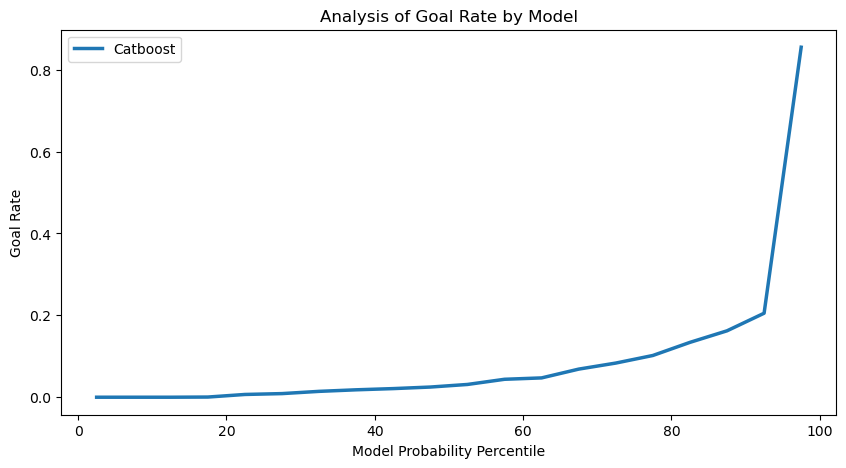

In [36]:
other_ml_models.generate_goal_rate_plot("Catboost", df_prob_bined, experiment)

### Cumulative Goal Analysis

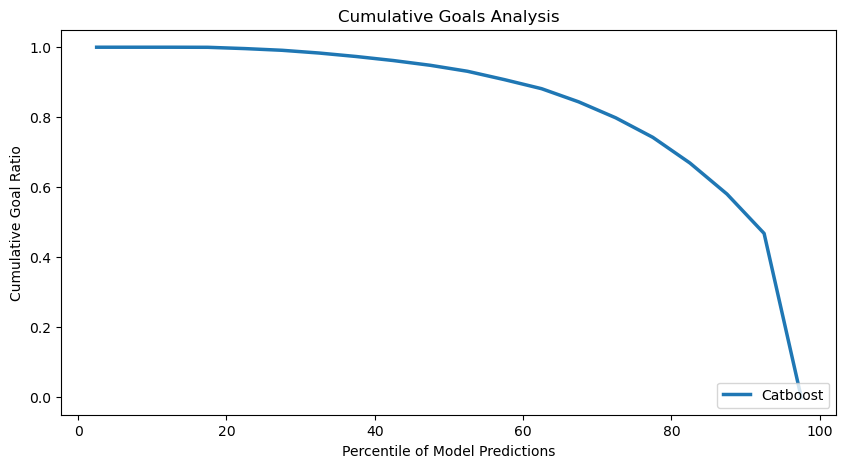

In [37]:
other_ml_models.visualize_cumulative_goals("Catboost", df_prob_bined, experiment)

### Calibration curve

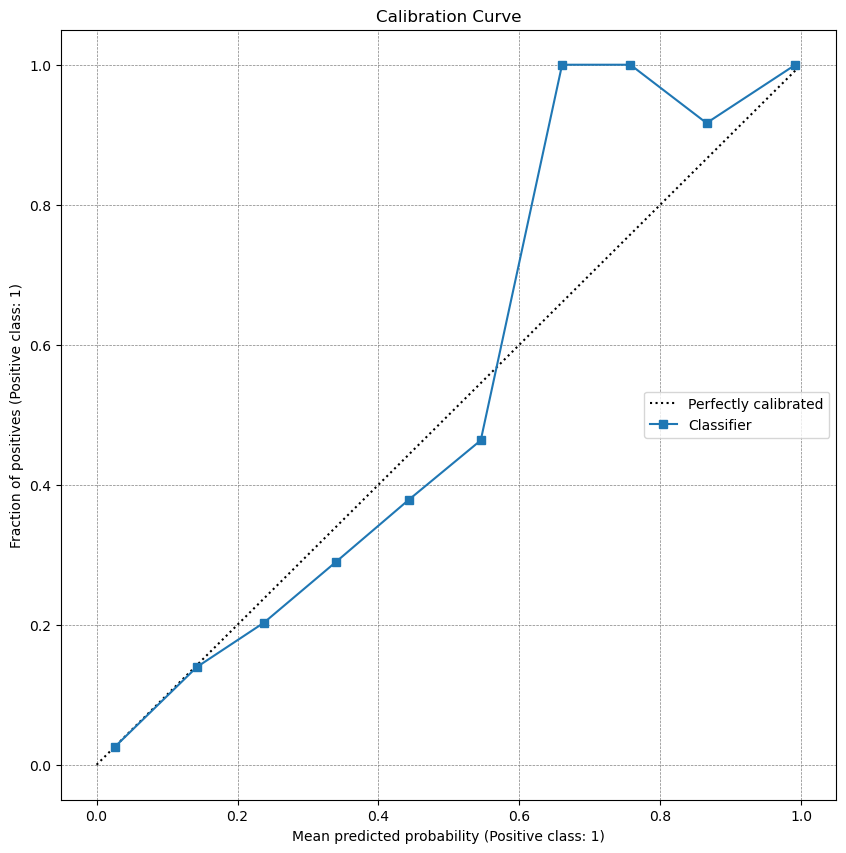

In [38]:
other_ml_models.plot_calibration_curve(y_test, preds_prob, experiment)

### Save Model

In [39]:
import pickle

In [41]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
pickle.dump(cat_best_pipe, open('models/cat_boost.sav', 'wb'))
experiment.log_model("Cat Boost Clf", 'models/cat_boost.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=064e0376353f46749539d272f65ae679&experimentKey=5099680072f7468a9e7d2cec05526378',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=064e0376353f46749539d272f65ae679&experimentKey=5099680072f7468a9e7d2cec05526378',
 'assetId': '064e0376353f46749539d272f65ae679'}

In [42]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/5099680072f7468a9e7d2cec05526378
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9478330489012494
COMET INFO:     f1        : 0.6034593209481102
COMET INFO:     precision : 0.9879391714735186
COMET INFO:     recall    : 0.434401660133733
COMET INFO:   Parameters:
COMET INFO:     model_type : Catboost
COMET INFO:     param_grid : {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
            